# Point Patterns G, F, K, and L Functions

Created by: Derek Robinson <br>
Last Updated: January 28, 2021

### Learning Objectives

In this Jupyter Notebook you will learn or review how to
<ul>
    <li> calculate distances between points within a single layer, </li>
    <li> calculate distances between points in two different layers,</li>
    <li> identify the minimum nearest neighbour distance for points, </li>
    <li> compute the mean nearest neighbour distance for a point pattern, </li>
    <li> examine the cumulative frequency distribution of nearest neighbour distances and compute the G(d) function, </li>
    <li> generate random points and calculate the frequency distribution of nearest neighbour distances in another spatial layer to compute the F(d) function, </li>
    <li> use an existing library to calculate and plot the K and L functions.</li>
</ul>

### Assignment Completion

For those in GEOG 318/PLAN 353 @UWaterloo, the assignment directions and submission requirements are provided on LEARN as a quiz that spans multiple days. To complete the quiz/assignment you will need to do the following:

<ul>
    <li> Complete this Jupyter Notebook.</li>
    <ul>
        <li> To advance to the next text cell or execute the code in a cell hold <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Shift</mark></font> and press <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Enter</mark></font> </li>
        <li> If there is a method for which you would like to know more about its parameters or how it works then you can place your cursor on the method and press <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5">Shift + Tab</mark></font> and a help box will appear that you can expand and scroll through.</li>
    </ul>
    <li> Complete the Quadrat Analysis Quiz/Assignment in LEARN, which may require you to </li>
    <ul>
        <li> copy results from your notebook into the LEARN input boxes, </li>
        <li> take screen captures of your notebook output and submit them via LEARN, or </li>
        <li> change values in the Jupyter Notebook and re-execute cells/code to obtain new results. </li>
    </ul>
    <li> <b>While you may discuss course content with your classmates, you are to complete the assignment individually.</b></li>
</ul>

### Problem Statement & Data

In this notebook we will explore the use of the G, F, K, and L functions for point pattern analysis. These functions give us insight into how clustered or dispersed our data are, among other useful information. 

We will use point pattern data of Home Depot stores located in Ontario, Canada, in 2014. In this Notebook you will compute the G, F, K, and L functions and plot their results. 

**While the methods below use store location data, they are applicable to point data representing other phenomena (e.g., wetland, wildlife, school, or crime locations)**.

### Lets get started

Sometimes when running functions and code in R you will receive warnings. These are displayed in pink in Jupyter Notebook following the execution of a cell. The warnings arise for a variety of reasons like a parameter was not specified so a default will be used. In creating these notebooks I have reviewed the warnings and they do not affect the results. The next line of code turns them off so that you are not confused or worried about them. However, if you would like to see them you may restart the notebook and comment the following cell code or skip executing it.

In [1]:
options(warn=-1)
# command to turn warnings on
# options(warn=0)

We need to use several methods in the `rgdal` package. First try loading the packages into your r library and if you get an error then uncomment the install command and execute the cell to install the package.

In [2]:
library(rgdal)

Loading required package: sp

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.4, released 2020/10/20
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/rgdal/proj
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.



Import the shapefiles we will work with using the `readOGR()` function from `rgdal`. This function allows us to define a shapefile as a usable object in R. The first input is the data source name (dsn) of the file. For us this will be `OntarioHomeDepot.shp`. Since we set the working directory `setwd()` above, we can just use the filename of the file we want to work with as the dsn. If you do not use `setwd()` earlier then the full path and filename must be used.

The second input requirement is `layer`, which is the layer name `OntarioHomeDepot`. Note that the specifications for dsn and layer may vary with the rgdal function being used, but for now we can use them as text descriptors of our file. 

In [3]:
OHD <- readOGR("OntarioHomeDepot.shp", "OntarioHomeDepot")
ONP <- readOGR(dsn="OntarioProvince.shp", layer="OntarioProvince")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/dtrobins/Documents/workspace/jupyterStats/courses-UWaterloo-318/GFKL/OntarioHomeDepot.shp", layer: "OntarioHomeDepot"
with 89 features
It has 15 fields
OGR data source with driver: ESRI Shapefile 
Source: "/Users/dtrobins/Documents/workspace/jupyterStats/courses-UWaterloo-318/GFKL/OntarioProvince.shp", layer: "OntarioProvince"
with 1 features
It has 9 fields


Lets map the data to see the distribution of points within the Province of Ontario. To do this we will load the `ggplot2` and `ggspatial` libraries. ggplot2 uses a data.frame for plotting, so we coerce the `OHD` data into a data.frame using the `data.frame()` function.

Regions defined for each Polygons

Using plotunit = 'm'



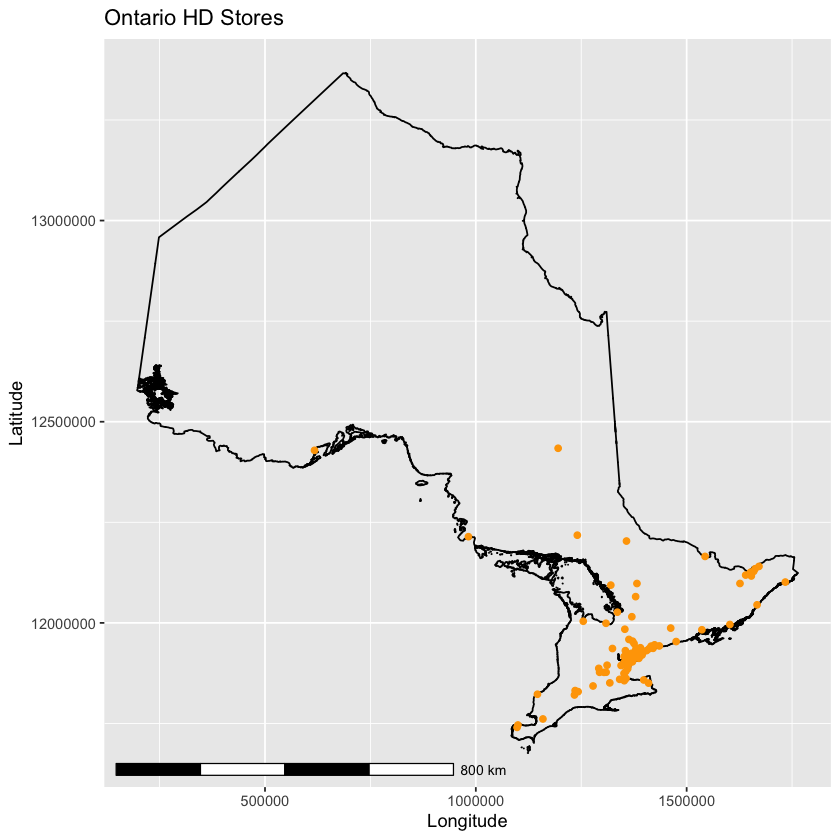

In [14]:
library(ggplot2)
library(ggspatial)

OHD_data <- data.frame(OHD)

g <- ggplot() + geom_polygon(data=ONP, aes(x=long, y=lat, group=group), color="black", fill=NA) 
g1 <- g + geom_point(data=OHD_data, aes(x=X, y=Y), color="orange")
g2 <- g1 + xlab("Longitude") + ylab("Latitude") + ggtitle("Ontario HD Stores") + annotation_scale(location = "bl", width_hint = 0.5)
plot(g2)

## Distance based measures

Distance-based measures offer an alternative to other approaches for describing and quantifying point pattern data (e.g., quadrat analysis, density-based measures). Distance-based measures involve calculating distances between points (a.k.a. events), which can provide us with a direct description of the second-order properties (i.e., interaction effects) of a point pattern.

Perhaps the easiest way to start with distance based measures is to <b>compute the distance between each point and all other points in the pattern</b>. We can do this quite easily using the `dist` function to compute the Euclidean distances between pairs of points <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><b>s</b><sub>i</sub></mark></font> and <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><b>s</b><sub>j</sub></mark></font>using the following equation:



<img class="one" src="Euclidean.png" width="300" height="300"><br>

To create spatially usable coordinates for our distance calculations, we need to first use the `coordinates()` function from the package `sp`. Load the package and then apply the `dist()` function. You can uncomment the `#print(d)` command and run or rerun the cell if you would like to see the distance values between two points.

In [5]:
library(sp)
xy <- coordinates(OHD)
d <- dist(xy)
#print(d)

Next we will convert the `data.frame` to a matrix using the `as.matrix()` function and fill in the diagonals with a value of `NA` using the `diag()` function. We apply the NA value to the diagonals since there can be no measured distance between a point and itself AND we do not want to affect calculations with the matrix that compute the nearest neighbour or mean nearest neighbour among other calculations we may do.

In [6]:
distMatrix <- as.matrix(d)
diag(distMatrix) <- NA

# Optional Viewing
# show the first 5 rows and columns
#distMatrix[1:5, 1:5]
# or show the entire matrix, here you should see all 89 points listed as rows and columns
#distMatrix

Now that we have a distance matrix `distMatrix` we can identify the smallest distance in each row (i.e., the minimum distance between the point represented by the row and all other points). To do this, we will use the `apply()` function. We will give that function our distance matrix `distMatrix`, tell it to work on the rows `1` (a value of two tells the function to work on each column), tell it to return the `min` value, and to remove NA values (i.e., `na.rm=TRUE`). The function will return to `dmin` <b>a vector of the minimum nearest neighbour distance (NND) for each point (row) in our data</b>.

In [7]:
dmin <- apply(distMatrix, 1, min, na.rm=TRUE)
#print(minNND)
#head(minNND)

With our minimum nearest neighbour distance `dmin` vector, we can compute the mean nearest neighbour distance using the `mean()` function, which implements the following equation for us:

<img class="one" src="meanNND.png" width="300" height="300"><br>

where we sum all our minimum distances for each point <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><b>s</b><sub>i</sub></mark></font> and divide them by the total number of points <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><i>n</i></mark></font>.

In [8]:
meanNND <- mean(dmin)
print(meanNND)

[1] 29171.7


It is always a good idea to visualize your intermediate steps, results, and processes you are conducting to ensure they are producing the results you are expecting. Lets <b>identify what are the nearest neighbour point IDs for each of our stores</b>. To do this we will use the `which.min` function to identify (for each point) which point is its nearest neighbour. Again we use the `apply()` function on our distance matrix `distMatrix` with a parameter of `1` specifying to apply the `which.min` function on each row. We store the results in a the which distand minimum `wdmin` variable and then we print it out to see what is in our variable.

In [9]:
wdmin <- apply(distMatrix, 1, which.min)
wdmin

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
47 19 60 42 65 38 50 36 15 61 60 59 34 87 45 11  2 72 40 45 76 69 31 72 63 60 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
58 56 62 82 18 16 71 13 86  8 62 52 55  1 74  4 61 51 20 55 22 89 76  7 16 38 
53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 
79 85 46 28 42 27 80 26 43 66 25 65 81 77 81 79 22 80 33 18 64 41 52 49 24 54 
79 80 81 82 83 84 85 86 87 88 89 
68 70 65 30 82 14 54 35 14 10 85

We can now visualize our points and their neighbours. Points that have the `farthest nearest neighbours are plotted in blue` and their `nearest neighbours have a red circle around them`. All other points remain in orange. Once you execute the next cell to plot the data, <b>remember that you can right click on the map and open it in a new tab</b> to see the results more clearly. This step was inspired by code provided in the `R Companion to Geographical Information Analysis` https://rspatial.org/raster/rosu/Chapter5.html#distance-based-measures, which also demonstrates how lines can be drawn between points and their nearest neighbours.

In [10]:
#farthest n points
npts = 5
# order the dmin distance vector in reverse
ord <- rev(order(dmin))
# select out the first 1 to npts, which represent the points that have the farthest neighbours
farpts <- ord[1:npts]
# identify the nearest neighbour points to our set that have the farthest neighbours
neighbours <- wdmin[farpts]

# extract out the npts from our original point pattern data
farPts <- data.frame(xy[farpts,])
# extract out the neighbours of our npts from our original point pattern data
farPtsNN <- data.frame(xy[neighbours, ])

# add to our earlier plot the npts that have the farthest neighbours
gFar25 <- g2 + geom_point(data=farPts, aes(x=coords.x1, y=coords.x2), color="blue", fill=NA) + ggtitle("Stores with farthest neighbours (blue) and their neighbours (red circles)")
# add to our plot the neighbours of our npts that have the farthest neighbours
gFar25wNN <- gFar25 + geom_point(data=farPtsNN, aes(x=coords.x1, y=coords.x2), color="red", fill=NA, shape = 21, size = 3, stroke = 1)
# show me the plot
plot(gFar25wNN)


ERROR: Error in eval(expr, envir, enclos): object 'g2' not found


# G Function
With our matrix of distances `distMatrix` providing distance measurements between every point in our point pattern, we can start to analyse the pattern using distance-based functions. The first function we are going to work with is the `G Function`. Instead of summarizing the data using the mean as we did with the mean nearest neighbour distance `meanNND`, we are going to <b>examine the cumulative frequency distribution of nearest neighbour distances</b>. 

In this case we will determine the cumulative frequency of nearest neighbour distances using the following equation:

<img src="gfunction.png" alt="Drawing" style="width: 200px;"/>

which can be read as the number `#` of points in our point pattern `s` with a minimum distance <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><i>d</i><sub>min</sub>(<b>s</b><sub>i</sub>)</mark></font> less than a distance threshold <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><i>d</i></mark></font>, divided by the number of points in our point pattern <font style="font-family:'Courier New'"><mark font-family="Courier New" style="background-color: #F5F5F5"><i>n</i></mark></font>.

We can operationalize this in R by sorting our distances using the `sort()` function. We then use the `sapply()` function that works similar to the `apply()` function we used earlier. In this case we will compute how many elements (numbers) in our `dmin` vector are less than each element in our `sortDists` vector, storing the results in `Gd`. Then we will normalize our Gd vector to a scale of 0 to 1. Lastly, we plot our distances on the x-axis and Gd results on the y-axis.

In [ ]:
sortDists <- sort(dmin)
# Compute how many dmin elements there are with distances smaller than each value (x) in our sortDists vector
Gd <- sapply(sortDists, function(x) sum(dmin < x))
# Normalize to get G(d) values between 0 and 1
Gd <- Gd/length(dmin)
plot(sortDists, Gd, main = "G function for minNN store distances", xlab="Distance")

# F Function


In this next section we will compute the F Function. The G Function used distances between all points in our point pattern. However, the F Function computes distances between points in our pattern and randomly generated points. The `spdep` library facilitates random point generation. Load the `spdep` library into our notebook.

In [11]:
library(spdep)

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Linking to GEOS 3.8.1, GDAL 3.1.1, PROJ 6.3.1



Next we will use the `spsample` to generate a spatial sample of `120` points that reside within our Province of Ontario boundary `ONP` at `random`. Lets store these points in an object named `randPoints`.

In [20]:
randPoints <- spsample(ONP,n=1200,"random")

Since you are curious what is in our `randPoints` object, use the `head()` function to see the class and contents of the object.

In [ ]:
head(randPoints)

Earlier we plotted the store point locations in orange within the Province of Ontario. The object at that point (prior to us adding the nearest neighbour symbology) was `g2`. Lets add to that g2 map our new random points. First we need to coerce the points to a data frame using the `data.frame()` function. How did I know to do that? I didn't. I received an error and then had to look up the ggplot2 documentation to tell me the format the ggplot functions require the data to be in for plotting. Then we add our `geom_point()` to our map and <b>plot store locations and random points</b>.

Using plotunit = 'm'



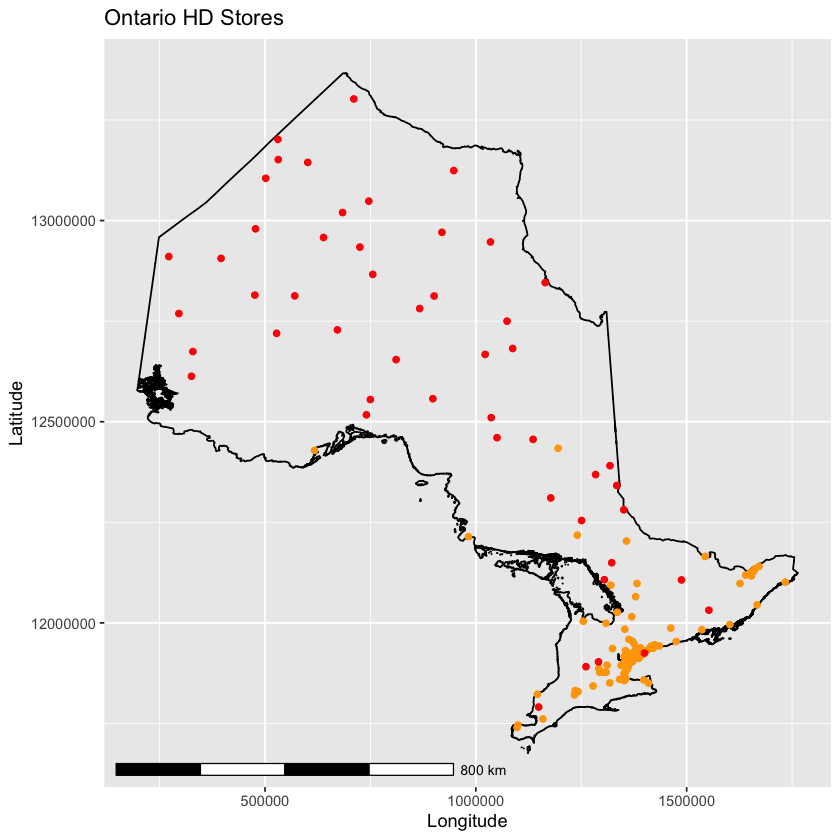

In [15]:
#Plot
randPoint_data <- data.frame(randPoints)
#randPoint_data <- fortify(randPoints)
g3 <- g2 + geom_point(data=randPoint_data, aes(x=x, y=y), color="red")
plot(g3)

The plot worked well, but we need to use these points in another function that requires them to be formal coordinates. So next we use the `coordinates()` function to transform our `randPoint_data` into coordinates and store them in an object `randxy`.

In [16]:
# creates an n x 2 matrix where the 2 represents a column for x and a column for y
randxy <- coordinates(randPoint_data)
#randxy

Now that we have the random coordinates we need to identify the boundaries of our data so that we can compute the distances between our random points `randxy` and our store locations in `OHD`. To do this we use need to use and load the `spatstat` library.

In [17]:
#install.packages("spatstat")
library(spatstat)

Loading required package: spatstat.data

Loading required package: nlme

Loading required package: rpart


spatstat 1.64-1       (nickname: ‘Help you I can, yes!’) 
For an introduction to spatstat, type ‘beginner’ 



Note: spatstat version 1.64-1 is out of date by more than 9 months; we recommend upgrading to the latest version.



The `spatstat` library has a `crossdist()` function that will <b>calculate the distances between points in two different spatial point patterns</b>. However the point patterns must by of `ppp` object type. To convert our `OHD` store point data to a ppp type we will use the `ppp()` function and need to give it the x locations the y locations  and the x range `c(ONP@bbox[1], ONP@bbox[3])` and the y range `c(ONP@bbox[2], ONP@bbox[4])`. We can use the same process for our randomly generated points `randPoints`. We use the same Province of Ontario bounding box to ensure all points are captured. With the two `ppp` objects we can calculate the distance between every point in `OHD_ppp` with every point in `randPoints_ppp` with the `crossdist()` function.

In [18]:
OHD_ppp <- ppp(OHD$X, OHD$Y, c(ONP@bbox[1],ONP@bbox[3]), c(ONP@bbox[2], ONP@bbox[4]))
randPoints_ppp <- ppp(randPoints$x, randPoints$y, c(ONP@bbox[1],ONP@bbox[3]), c(ONP@bbox[2], ONP@bbox[4]))
crossDists <- crossdist(OHD_ppp, randPoints_ppp)

Next we will use the `apply()` function with our cross point pattern distances (between observed store points and randomly generated points) similar to how we used the apply function in our Gd calculations above. We will search the rows `1` for the minimum `min` value and ignore any NA values `na.rm=TRUE`. We will store a vector of our minimum distances for each store to a random point in an object named `minNNDF` (minimum nearest neighbour distance F function). The we will sort these minimum distances using the `sort()` function. As we did with the Gd function we will use the `sapply()` to sum the number of points from `minNNDF` that exist below each value in our `sortFDists` vector. Next we normalize the Fd values between a range of 0 to 1 and plot the Fd values on the y-axis and the distances on the x-axis.

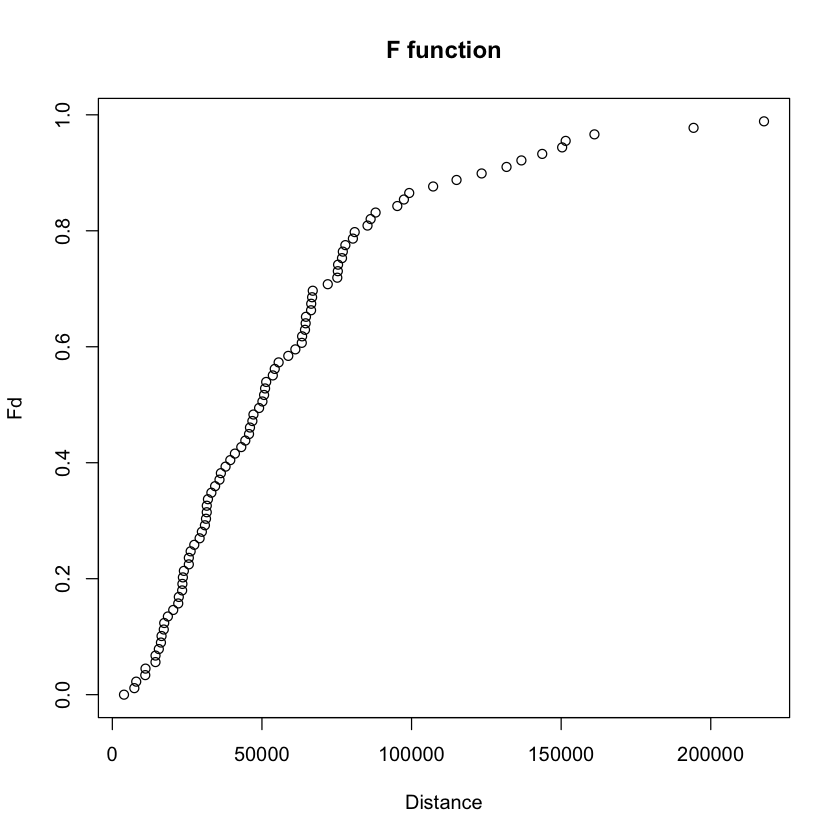

In [19]:
minNNDF <- apply(crossDists, 1, min, na.rm=TRUE)
sortFDists <- sort(minNNDF)
# Compute how many cases there are with distances smaller than each x
Fd <- sapply(sortFDists, function(x) sum(minNNDF < x))
# Normalize to get values between 0 and 1
Fd <- Fd/length(minNNDF)
plot(sortFDists, Fd, main = "F function", xlab="Distance")

Now that we have both the F and G functions calculated and plotted. We can <b>combine and compare the F and G functions</b> on one plot.

In [ ]:
plot(sortDists, Gd, type='l', lwd=2, col='red', las=1,
    ylab='F(d) or G(d)', xlab='Distance', yaxs="i", xaxs="i")
lines(sortFDists, Fd, lwd=2, col='blue')
legend(1200, .3,
   c(expression(italic("G")["d"]), expression(italic("F")["d"])),
   lty=1, col=c('red', 'blue'), lwd=2, bty="n")

# K Function

The K Function is a distance-based measure, but it is not a frequency distribution as the values plotted in the K Function graph are not dependent on the previous values (as was the case with the Gd and Fd functions). The function works by calculating a series of distances `d` for each point si in pattern `S`. The distances `d` are used as the radius of a circle and the number of points within the circle are counted. Then we compute the mean event count by dividing our result by `n` the number of events for all circles of `d` for our point of interest. Lastly we divide the mean by the point pattern intensity (i.e., the even density lambda). The process is repeated for all points.

We could create code to conduct these calculations. Instead we will use the K Function estimator `Kest()` provided by the `spatstat` library. 

The problem with functions like the K Function is that the concentric circles can extend beyond the boundaries and generate edge effects in our analysis. There are multiple ways to deal with edge effects (e.g., creating a guard zone, toroid, or some form of correction). The `Kest()` function defaults to display several corrections. So lets first see what the uncorrected K Function results look like by specifying the `correction="none"`. In the generated legend you will see K-hat values with a K<sub>un</sub> which stands for uncorrected and a K<sub>pois</sub> for the expected value of K using the event intensity (lambda) and a poisson distribution.

In [ ]:
K <- Kest(OHD_ppp, correction="none")
plot(K)

Now lets use a `correction="border"`, which is the simplest type of correction and removes those points that have significant d values that intersect the border.

In [ ]:
Kbrd <- Kest(OHD_ppp, correction="border")
plot(Kbrd, main = "K function with reduced sample correction for edge effects")

### L Function

As you may have noticed in the previous plots, the values of K can become very large as distance increases, which can it difficult to see small differences when comparing plots. To remedy this issue, the L Function was developed to transform K(d) for comparison between observed and expected values. When a match occurs between the observed and expected K(d) values then L(d) = 0. 

In [ ]:
plot(K, sqrt(un/pi) ~ r, ylab="L(r)", main="L function for Store Pattern")

# Congratulations!

**You have reached the end of the G, F, K, and L Functions notebook**